In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time

from dotenv import load_dotenv
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from msrest.authentication import CognitiveServicesCredentials

In [2]:
'''
Authenticate
Authenticates your credentials and creates a client.
'''

load_dotenv('azure.env')

subscription_key = os.getenv("AZURE_SUBSCRIPTION_KEY")
endpoint = os.getenv("AZURE_ENDPOINT")

if not subscription_key or not endpoint:
    raise ValueError("Environment variables are missing!")

cognitive_services_credentials = CognitiveServicesCredentials(subscription_key)

computervision_client = ComputerVisionClient(endpoint, cognitive_services_credentials)

'''
END - Authenticate
'''

'\nEND - Authenticate\n'

In [3]:
# Funtie pentru a obtine rezultatul OCR
def get_ocr_result(image_path):
    with open(image_path, "rb") as image_stream:
        ocr_result = computervision_client.read_in_stream(
            image_stream, language="en", raw=True
        )

    # Aflam ID-ul operatiei
    op_location = ocr_result.headers["Operation-Location"]
    op_id = op_location.split("/")[-1]

    # Interogam
    while True:
        result = computervision_client.get_read_result(op_id)
        if result.status not in ['notStarted', 'running']:
            break
        time.sleep(1)

    return result

# Extragem textul si casetele de delimitare din rezultatul OCR
def extract_text_and_bounding_boxes(result):
    bounding_boxes = []
    text = ""

    if result.status == OperationStatusCodes.succeeded:
        for text_result in result.analyze_result.read_results:
            for line in text_result.lines:
                text += line.text + "\n"
                bounding_boxes.append(line.bounding_box)

    return text, bounding_boxes

# Convertim caseta de delimitare in formatul (x1, y1, x2, y2)
def to_rect(box):
    x_coords = [box[i] for i in range(0, len(box), 2)]
    y_coords = [box[i] for i in range(1, len(box), 2)]
    return [min(x_coords), min(y_coords), max(x_coords), max(y_coords)]

# Calculam scorul IoU pentru doua casete de delimitare
def iou(box1, box2):
    rect1 = to_rect(box1)
    rect2 = to_rect(box2)

    x_left = max(rect1[0], rect2[0])
    y_top = max(rect1[1], rect2[1])
    x_right = min(rect1[2], rect2[2])
    y_bottom = min(rect1[3], rect2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0  # Nicio intersectie

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    rect1_area = (rect1[2] - rect1[0]) * (rect1[3] - rect1[1])
    rect2_area = (rect2[2] - rect2[0]) * (rect2[3] - rect2[1])
    union_area = rect1_area + rect2_area - intersection_area

    return intersection_area / union_area

# Calculam scorurile IoU pentru mai multe casete de delimitare
def calculate_iou_scores(ground_truth_boxes, bounding_boxes, iou_threshold=0.3):
    iou_scores = []
    matches = []

    for gt_box in ground_truth_boxes:
        for pred_box in bounding_boxes:
            iou_score = iou(gt_box, pred_box)
            iou_scores.append(iou_score)
            matches.append(iou_score >= iou_threshold)

    return iou_scores, matches

# Desenam casetele de delimitare pe imagine
def draw_bounding_boxes(image_path, bounding_boxes):
    image = cv2.imread(image_path)

    for box in bounding_boxes:
        points = [(box[i], box[i+1]) for i in range(0, len(box), 2)]
        points = [(int(x), int(y)) for (x, y) in points]

        cv2.polylines(image, [np.array(points)], isClosed=True, color=(0, 255, 0), thickness=2)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

IoU Scores: [0.0, 0.0, 0.0, 0.0]
Matches (IoU > 0.3): [False, False, False, False]


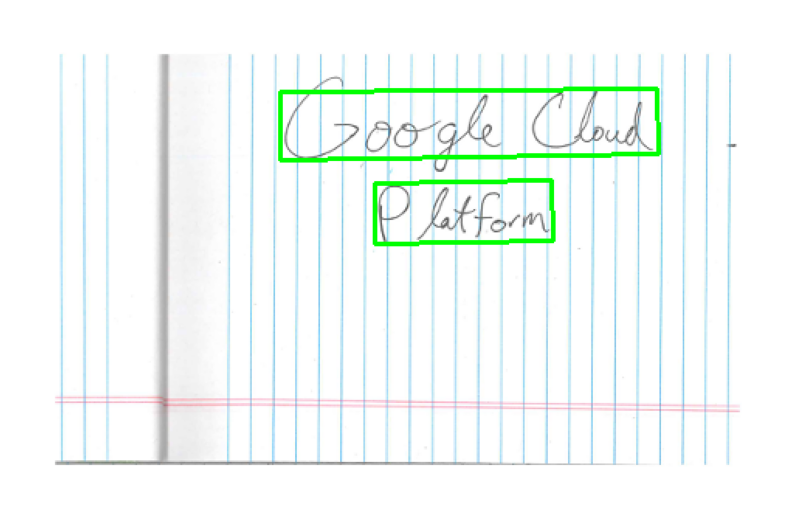

In [4]:
image_path = "data/test1.png"

result = get_ocr_result(image_path)

text, bounding_boxes = extract_text_and_bounding_boxes(result)

ground_truth_boxes = [
    [70, 300, 1200, 250, 1250, 400, 75, 380],
    [137, 712, 1050, 710, 1300, 360, 160, 315]
]

iou_scores, matches = calculate_iou_scores(ground_truth_boxes, bounding_boxes)

print(f"IoU Scores: {iou_scores}")
print(f"Matches (IoU > 0.3): {matches}")

draw_bounding_boxes(image_path, bounding_boxes)